In [7]:
import pandas as pd

In [8]:
data=pd.read_csv("trainingdata.csv")

In [9]:
data.drop(columns="Unnamed: 0",inplace=True)

In [10]:
data.drop(columns="date",inplace=True)

In [11]:
data

,classification,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Crossed,Fee
0,Fear,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1897.900,0.0967,183.53,BUY,2023-01-05 01:06:00,0.0000,Open Long,0.00000,True,0.000000
1,Fear,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1897.900,0.0824,156.39,BUY,2023-01-05 01:06:00,0.0967,Open Long,0.00000,True,0.000000
2,Fear,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,1898.600,0.0722,137.08,BUY,2023-01-05 01:06:00,0.1791,Open Long,0.00000,True,0.000000
3,Neutral,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.100,0.4933,1100.11,BUY,2023-05-12 03:11:00,0.0000,Open Long,0.00000,True,0.275027
4,Neutral,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,2230.100,0.8681,1935.95,BUY,2023-05-12 03:11:00,0.4933,Open Long,0.00000,True,0.483987
...,...,...,...,...,...,...,...,...,...,...,...,...,...
167852,Greed,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,HYPE,25.641,28.7200,736.41,BUY,2025-05-02 01:22:00,-205.9800,Close Short,18.99828,True,0.257743
167853,Greed,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,HYPE,25.641,177.2600,4545.12,BUY,2025-05-02 01:22:00,-177.2600,Close Short,117.25749,True,1.590793
167854,Greed,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,HYPE,26.600,298.8700,7949.94,SELL,2025-05-02 11:33:00,0.0000,Open Short,0.00000,False,0.794994
167855,Greed,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,HYPE,26.700,297.7500,7949.93,SELL,2025-05-02 11:39:00,-298.8700,Open Short,0.00000,False,0.794992


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [12]:
# 1. Feature Engineering: Aggregate by Trader
def prepare_trader_features(df):
    trader_features = df.groupby('Account').agg(
        Total_Volume=('Size USD', 'sum'),
        Trade_Count=('Account', 'count'),
        Total_PnL=('Closed PnL', 'sum'),
        Dominant_Sentiment=('classification', lambda x: x.mode()[0])
    ).reset_index()
    
    # Create target: Profitability Bucket (3 classes: Loss, Neutral, Profit)
    trader_features['Profitability_Bucket'] = pd.qcut(
        trader_features['Total_PnL'], q=3, labels=['Loss', 'Neutral', 'Profit']
    )
    return trader_features

In [17]:
# 2. Clustering: Behavioral Archetypes
def cluster_traders(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[['Total_Volume', 'Trade_Count']])
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df['Archetype'] = kmeans.fit_predict(scaled_data)
    return df

In [18]:
# 3. Prediction: Profitability Model
def train_profitability_model(df):
    le = LabelEncoder()
    df['Sentiment_Code'] = le.fit_transform(df['Dominant_Sentiment'])
    
    features = ['Total_Volume', 'Trade_Count', 'Sentiment_Code']
    X = df[features]
    y = df['Profitability_Bucket']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    
    print(f"Model Accuracy: {clf.score(X_test, y_test):.2%}")
    print("Feature Importance:", dict(zip(features, clf.feature_importances_)))
    
    return clf

In [24]:
# --- Execution ---
df=data# Assuming standard pandas CSV/SQL load
processed_df = prepare_trader_features(df)
processed_df = cluster_traders(processed_df)
model = train_profitability_model(processed_df)

Model Accuracy: 50.00%
Feature Importance: {'Total_Volume': np.float64(0.43735873482326737), 'Trade_Count': np.float64(0.3965560230420869), 'Sentiment_Code': np.float64(0.1660852421346457)}


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



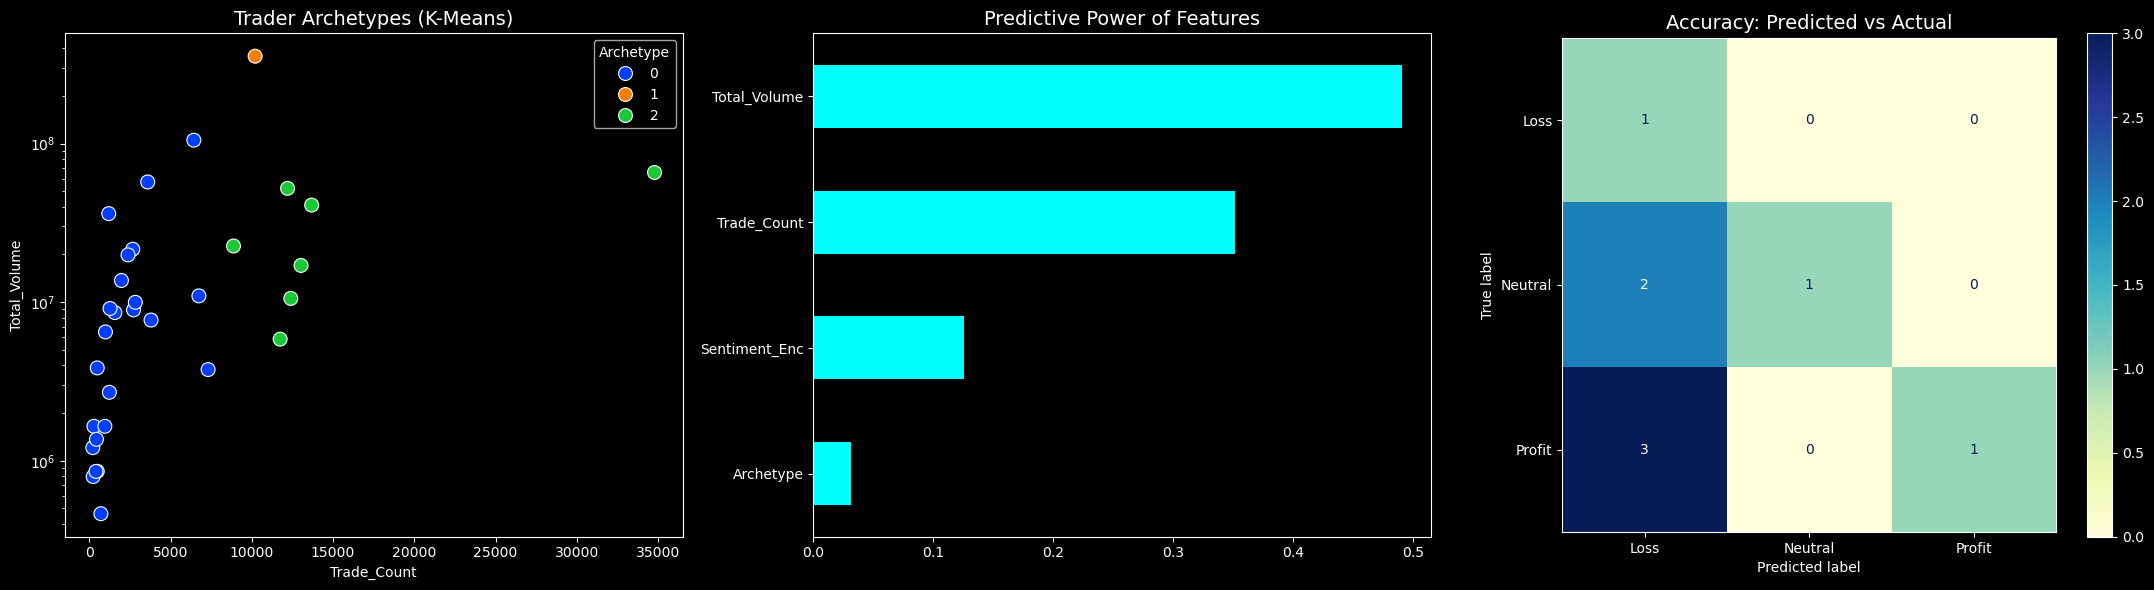


--- Model Performance Report ---
              precision    recall  f1-score   support

        Loss       0.17      1.00      0.29         1
     Neutral       1.00      0.33      0.50         3
      Profit       1.00      0.25      0.40         4

    accuracy                           0.38         8
   macro avg       0.72      0.53      0.40         8
weighted avg       0.90      0.38      0.42         8



In [35]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1. DATA PREPARATION & FEATURE ENGINEERING
def process_trading_data(df):
    # Aggregating by Account to find trader-level patterns
    trader_df = df.groupby('Account').agg({
        'Size USD': 'sum',
        'Account': 'count',
        'Closed PnL': 'sum',
        'classification': lambda x: x.mode()[0]  # Dominant Sentiment (Fear/Greed)
    }).rename(columns={'Size USD': 'Total_Volume', 'Account': 'Trade_Count', 'Closed PnL': 'Total_PnL'})

    # Target Variable: Profitability Buckets (Top, Mid, Bottom performers)
    trader_df['Profit_Bucket'] = pd.qcut(trader_df['Total_PnL'], q=3, labels=['Loss', 'Neutral', 'Profit'])
    
    # Encode Sentiment for the ML model
    le = LabelEncoder()
    trader_df['Sentiment_Enc'] = le.fit_transform(trader_df['classification'])
    return trader_df, le

# 2. THE TRAINING & CLUSTERING ENGINE
def run_ml_pipeline(trader_df):
    # A. Behavioral Clustering (Unsupervised)
    scaler = StandardScaler()
    cluster_features = scaler.fit_transform(trader_df[['Total_Volume', 'Trade_Count']])
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    trader_df['Archetype'] = kmeans.fit_predict(cluster_features)
    
    # B. Profitability Prediction (Supervised)
    X = trader_df[['Total_Volume', 'Trade_Count', 'Sentiment_Enc', 'Archetype']]
    y = trader_df['Profit_Bucket']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    return model, X_test, y_test, trader_df

# 3. COMPREHENSIVE TRAINING VISUALIZATION
def visualize_results(model, X_test, y_test, trader_df):
    plt.style.use('dark_background') # Using a "Trading Terminal" aesthetic
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # Plot 1: Cluster Visualization
    sns.scatterplot(data=trader_df, x='Trade_Count', y='Total_Volume', 
                    hue='Archetype', palette='bright', ax=axes[0], s=100)
    axes[0].set_title("Trader Archetypes (K-Means)", fontsize=14)
    axes[0].set_yscale('log')

    # Plot 2: Feature Importance (What drives profit?)
    feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
    feat_importances.sort_values().plot(kind='barh', ax=axes[1], color='cyan')
    axes[1].set_title("Predictive Power of Features", fontsize=14)

    # Plot 3: Confusion Matrix (Training Accuracy)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=['Loss', 'Neutral', 'Profit'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Loss', 'Neutral', 'Profit'])
    disp.plot(cmap='YlGnBu', ax=axes[2])
    axes[2].set_title("Accuracy: Predicted vs Actual", fontsize=14)

    plt.tight_layout()
    fig.savefig("graphs_and_tables/training")
    plt.show()

    # Print Text Metrics
    print("\n--- Model Performance Report ---")
    print(classification_report(y_test, y_pred))

# --- EXECUTION FLOW ---
# Assuming 'raw_df' is your initial dataframe
processed_data, encoder = process_trading_data(data)
ml_model, X_test, y_test, final_df = run_ml_pipeline(processed_data)
visualize_results(ml_model, X_test, y_test, final_df)